In [1]:
import pandas as pd
import numpy as np

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from keras.utils import plot_model

import shap
import lime

import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
base_folder = "/home/sunny/Data for ML Project"
project_folder = "Batch 3 Quantile Ranking"
batch = "/home/sunny/Batch3"
use_tickers_as_feature = False

if not os.path.exists(batch):
    os.mkdir(batch)

    
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    total_data.append(df.fillna(value=0).drop(columns=["ticker", "returns"]).values.tolist())
    labels.append(df["returns"].values.tolist())
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 131) (52, 505)


In [3]:
dfs = []
for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    dfs.append(df.fillna(value=0))
    
combined_df = pd.concat(dfs)
combined_df.head()

ticker  SQN_Q1_CI  SQN_Q2_CI  SQN_Q3_CI  SQN_Q4_CI  SQN_Q1  SQN_Q2  SQN_Q3  \
0      A        1.0        2.0        5.0        4.0     1.0     2.0     5.0   
1    AAL        2.0        4.0        4.0        1.0     3.0     4.0     2.0   
2    AAP        5.0        1.0        1.0        2.0     5.0     1.0     1.0   
3   AAPL        1.0        1.0        3.0        2.0     1.0     1.0     3.0   
4   ABBV        0.0        0.0        0.0        0.0     0.0     0.0     0.0   

   SQN_Q4  IV_calls_0  ...  zomma_puts_180  speed_puts_180  color_puts_180  \
0     4.0         2.0  ...             4.0             4.0             4.0   
1     1.0         0.0  ...             0.0             0.0             0.0   
2     2.0         3.0  ...             2.0             2.0             2.0   
3     1.0         2.0  ...             1.0             2.0             1.0   
4     0.0         0.0  ...             0.0             0.0             0.0   

   dual_delta_puts_180  dual_gamma_puts_180  IV_0  IV_30  IV_120  IV_180  \
0                  3.0                  2.0   2.0    3.0     2.0     2.0   
1                  0.0                  0.0   0.0    0.0     0.0     0.0   
2                  4.0                  4.0   3.0    1.0     3.0     3.0   
3                  4.0                  5.0   2.0    2.0     2.0     2.0   
4                  0.0                  0.0   0.0    0.0     0.0     0.0   

   returns  
0      1.0  
1      1.0  
2     -1.0  
3     -1.0  
4     -1.0  

[5 rows x 133 columns]

## Plotting Correlation Matrix

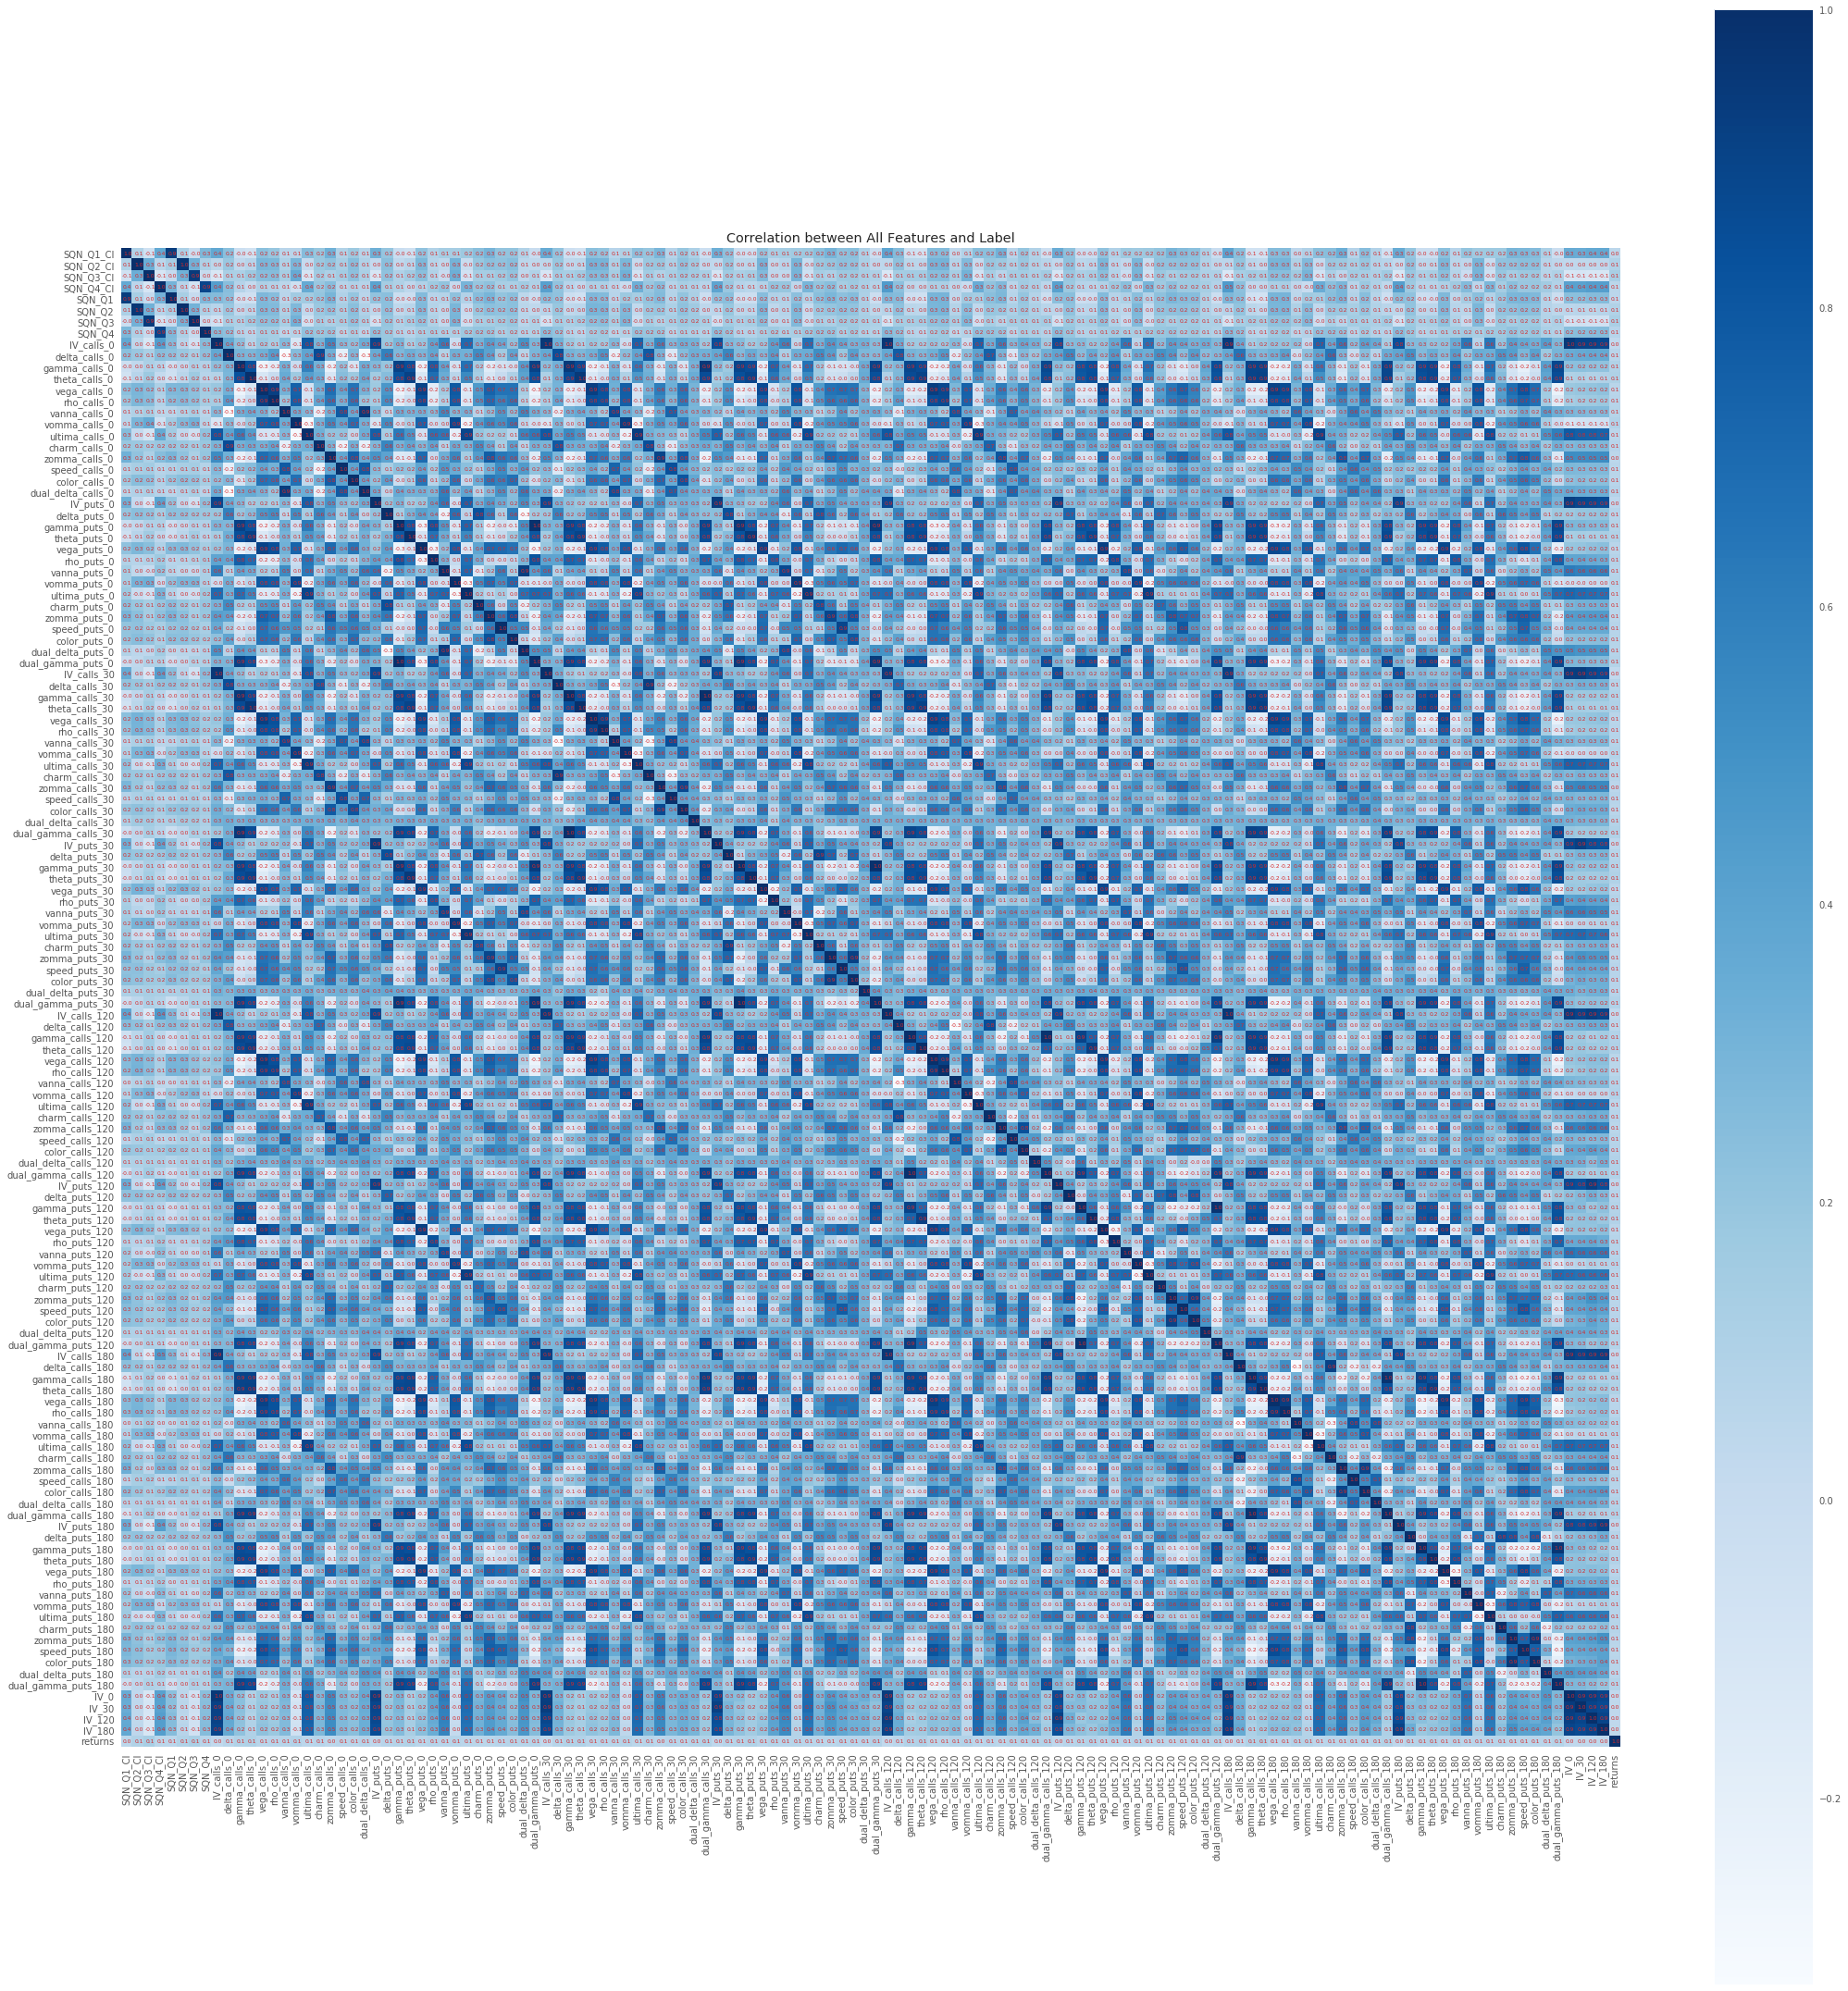

In [4]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,30))
    plot_correlation_matrix(combined_df.drop(columns=["ticker"]).corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


## P-values and F-values For Classification

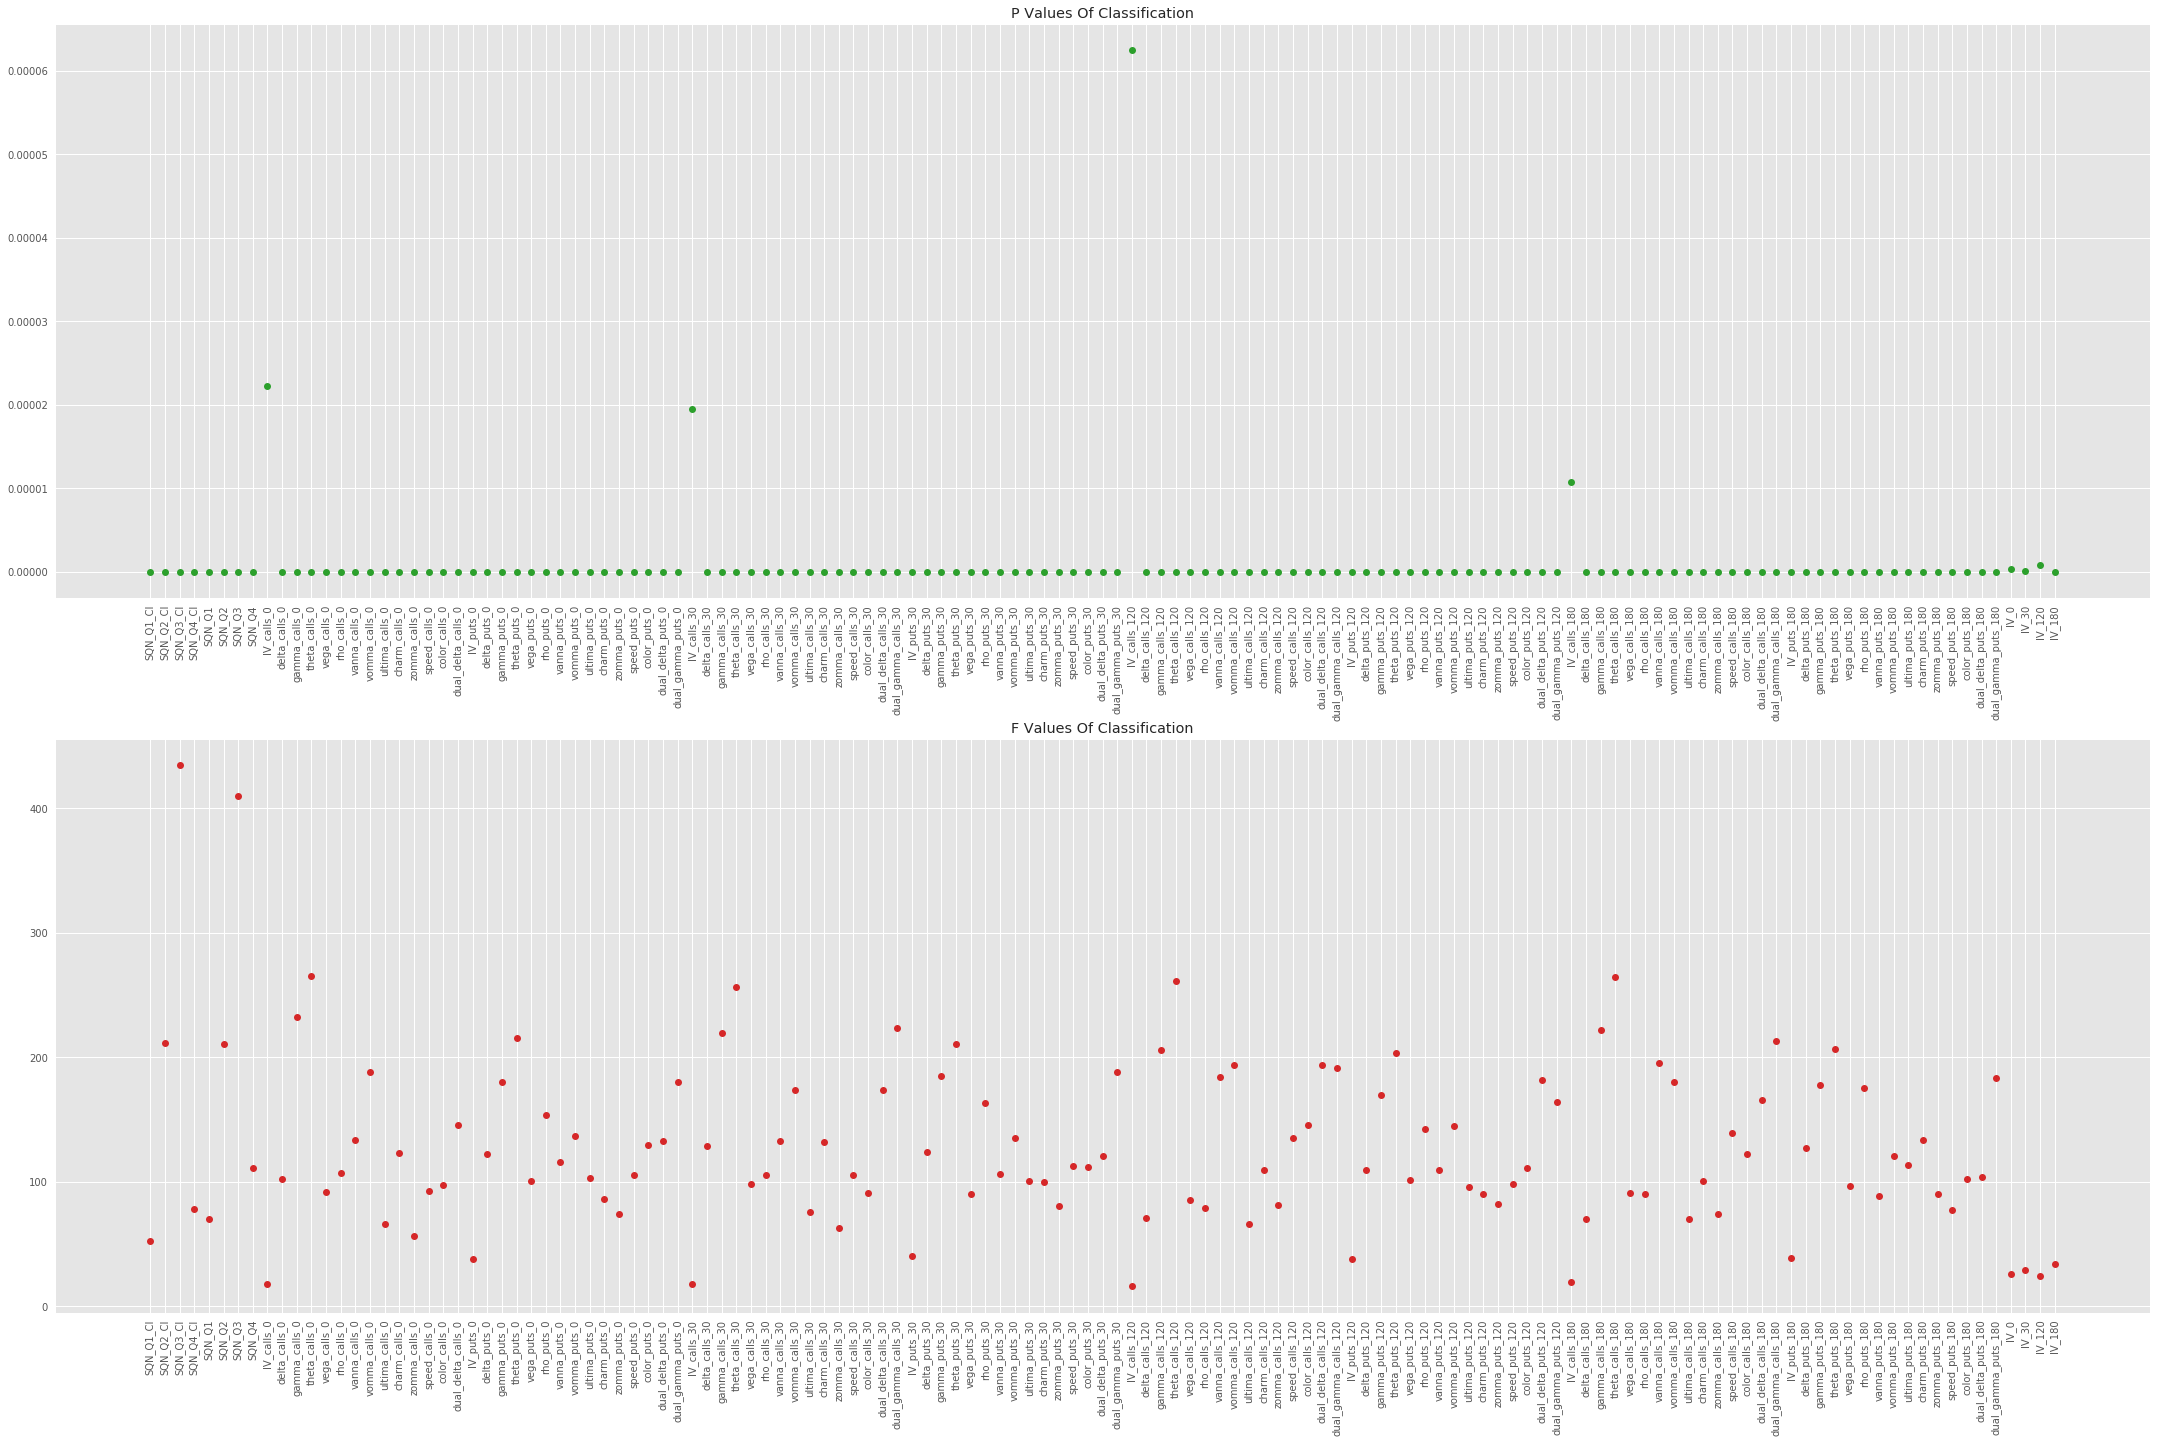

In [5]:
X = combined_df.drop(columns=["ticker","returns"])
X = MinMaxScaler().fit_transform(X)
Y = combined_df['returns'].values
Y = np.array([1 if y==1 else 0 for y in Y])

cols = combined_df.drop(columns=["ticker", "returns"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,20))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

In [4]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(actuals, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)
    
    
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

## 1. Dense Net V1

### Data Preparation

In [130]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    if use_tickers_as_feature:
        df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"]).fillna(value=0)
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 131) (52, 505)


In [131]:
X, Y = total_data[:-1], labels[1:]

print(X.shape, Y.shape)

X_train, X_test = X[:49], X[49:]
Y_train, Y_test = Y[:49], Y[49:]

X_train, X_val = X_train[:47], X_train[47:]
Y_train, Y_val = Y_train[:47], Y_train[47:]

#X_train, X_val, X_test = X_train[:-1], X_val[:-1], X_test[:-1]
#Y_train, Y_val, Y_test = Y_train[1:], Y_val[1:], Y_test[1:]

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(51, 505, 131) (51, 505)


((47, 505, 131), (2, 505, 131), (2, 505, 131), (47, 505), (2, 505), (2, 505))

In [132]:
X = X.reshape((-1, total_data.shape[-1]))
Y = Y.flatten()

print(X.shape, Y.shape)

X_train = X_train.reshape((-1, X_train.shape[-1]))
X_val = X_val.reshape((-1, X_val.shape[-1]))
X_test = X_test.reshape((-1, X_test.shape[-1]))

Y_train = Y_train.flatten()
Y_val = Y_val.flatten()
Y_test = Y_test.flatten()

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(25755, 131) (25755,)


((23735, 131), (1010, 131), (1010, 131), (23735,), (1010,), (1010,))

### Model Creation

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

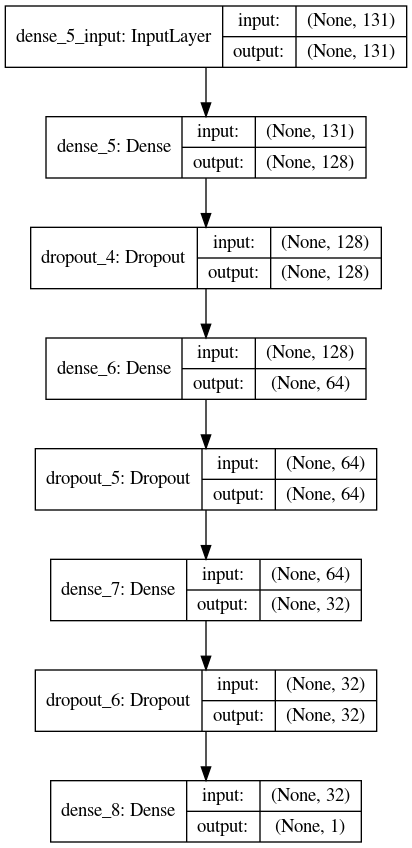

In [15]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(1,   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense1.png'))

### Model Compilation

In [16]:
dense_model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Model Training

In [17]:
history = dense_model1.fit(X_train, Y_train, batch_size=505, epochs=10, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 23735 samples, validate on 1010 samples
Epoch 1/10
23735/23735 [==============================] - 0s 16us/step - loss: 0.7234 - accuracy: 0.5226 - val_loss: 0.6928 - val_accuracy: 0.5228
Epoch 2/10
23735/23735 [==============================] - 0s 9us/step - loss: 0.6943 - accuracy: 0.5245 - val_loss: 0.6907 - val_accuracy: 0.5208
Epoch 3/10
23735/23735 [==============================] - 0s 9us/step - loss: 0.6886 - accuracy: 0.5219 - val_loss: 0.6886 - val_accuracy: 0.5208
Epoch 4/10
23735/23735 [==============================] - 0s 8us/step - loss: 0.6816 - accuracy: 0.5279 - val_loss: 0.6858 - val_accuracy: 0.5119
Epoch 5/10
23735/23735 [==============================] - 0s 9us/step - loss: 0.6739 - accuracy: 0.5296 - val_loss: 0.6847 - val_accuracy: 0.5188
Epoch 6/10
23735/23735 [==============================] - 0s 8us/step - loss: 0.6720 - accuracy: 0.5293 - val_loss: 0.6844 - val_accuracy: 0.5178
Epoch 7/10
23735/23735 [==============================] - 0s 9us/step - lo

### Visualizing Training Results

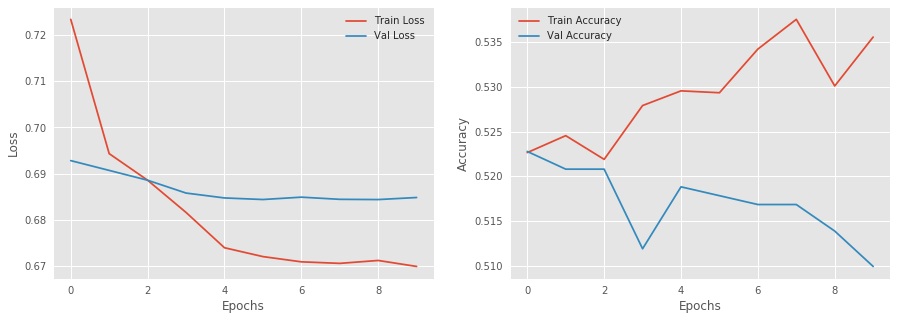

In [18]:
plot_loss_and_accuracy(history)

### Checking Accuracy On Test Data

In [19]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions.flatten()))

Accuracy : 0.458


In [20]:
#predictions_full = dense_model1.predict_classes(X)
#print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

In [21]:
probs = dense_model1.predict_proba(X).flatten()
probs[:10]

array([0.49567237, 0.5147012 , 0.4961759 , 0.49107844, 0.04206717,
       0.4914824 , 0.4741647 , 0.46782812, 0.4736232 , 0.47722876],
      dtype=float32)

### Printing & Visualizing Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.45      0.96      0.61       451
           1       0.64      0.05      0.09       559

    accuracy                           0.46      1010
   macro avg       0.54      0.51      0.35      1010
weighted avg       0.55      0.46      0.33      1010

Confusion Matrix : 
 [[435  16]
 [531  28]]


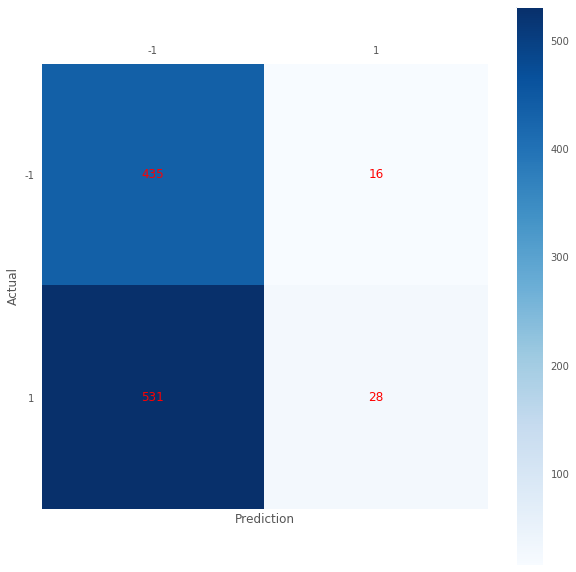

In [22]:
print_plot_metrics('DenseNetv1', Y_test, predictions.flatten())

In [23]:
print_weights_per_layer(dense_model1)

Layer : Dense : Weights : (131, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


### Visualizing Weights FOr Features

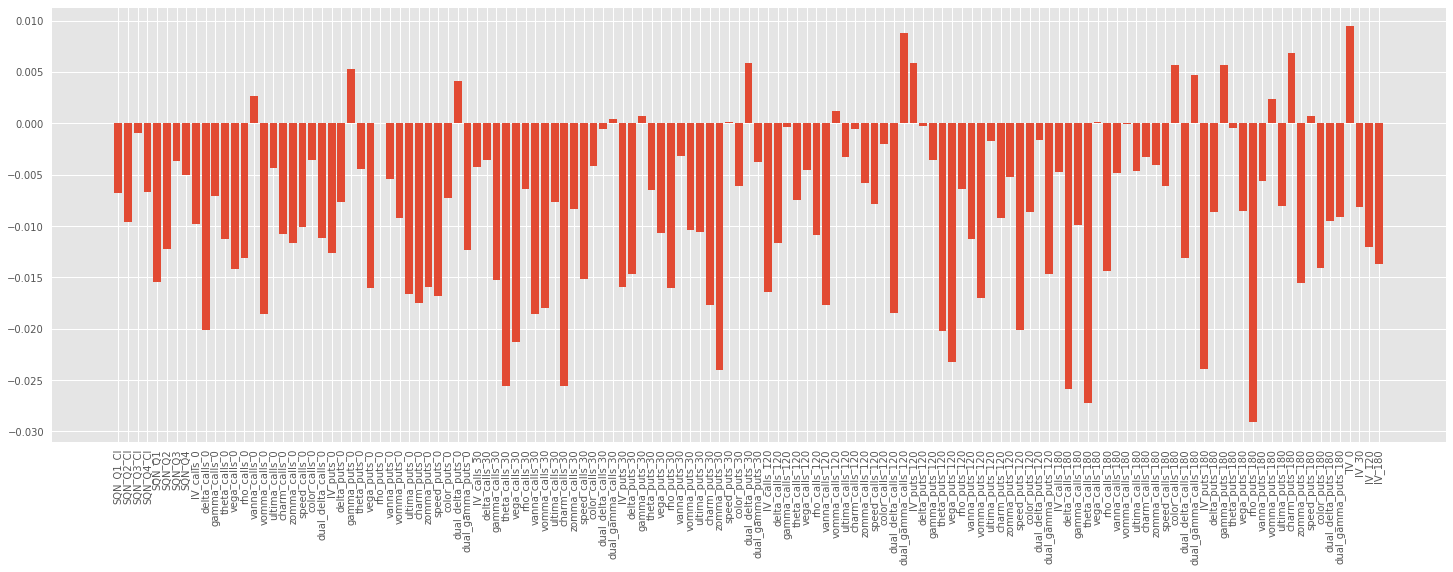

In [24]:
dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v1.png"), dpi=200)

In [25]:
feature_cols = combined_df.drop(columns=["ticker", "returns"]).columns.tolist()
if use_tickers_as_feature:
    feature_cols = feature_cols + combined_df[:505].ticker.values.tolist()

print(len(feature_cols))

131


In [133]:
j=3

def predict_dense1(data):
    probs = dense_model1.predict_proba(data)
    return np.array([[1-prob[0], prob[0]] for prob in probs])

def lime_viz(j, pred_func):
    print("Prediction Ticker : ", combined_df[:505].ticker[j])
    print("Prediction Values",Y_test[j])

    if use_tickers_as_feature:
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_cols,
                                                       class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                       training_labels=Y_train,
                                                       categorical_features=range(131,636),
                                                       categorical_names=dict([(i, [0,1]) for i in range(131,636)]),
                                                       verbose=True,)
    else:
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_cols,
                                                       class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                       training_labels=Y_train,
                                                       verbose=True,)

    exp_model = explainer.explain_instance(X_test[j], 
                                        pred_func, 
                                        labels=[0,1],
                                        num_features=X_train.shape[0])

    exp_model.show_in_notebook(show_table=True)
    
lime_viz(j, predict_dense1)

Prediction Ticker :  AAPL
Prediction Values 1
Intercept 0.5126342536701046
Prediction_local [0.52484529]
Right: 0.5151236057281494
Intercept 0.48736574632989516
Prediction_local [0.47515471]
Right: 0.4848763942718506


In [27]:
#explainer = shap.DeepExplainer(dense_model1, tf.convert_to_tensor(X_train[:10], dtype=tf.float32))
#shap_values = explainer.shap_values(X_test, check_additivity=False)

### Saving Model & Loading From Saved File

In [28]:
dense_model1.save(os.path.join(batch,"dense_classifier_v1.h5"))

In [29]:
dense_model1 = load_model(os.path.join(batch,"dense_classifier_v1.h5"))

dense_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

### Future Values Prediction

In [30]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    if use_tickers_as_feature:
        df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"])
    df = df.fillna(value=0)

    data = df.values
    #data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [31]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model1)

probs[:5], labels[:5]

(array([0.48751625, 0.48589206, 0.49456537, 0.49641925, 0.4968512 ],
       dtype=float32), array([-1, -1, -1, -1, -1]))

### Adding Probabilities to Combined Data Frame

In [32]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)

combined_df_final = combined_df.copy()
combined_df_final["DenseV1_Probs"] = tot_probs
combined_df_final["DenseV1_Preds"] = tot_labels

## 2. Dense Model V2

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               13200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

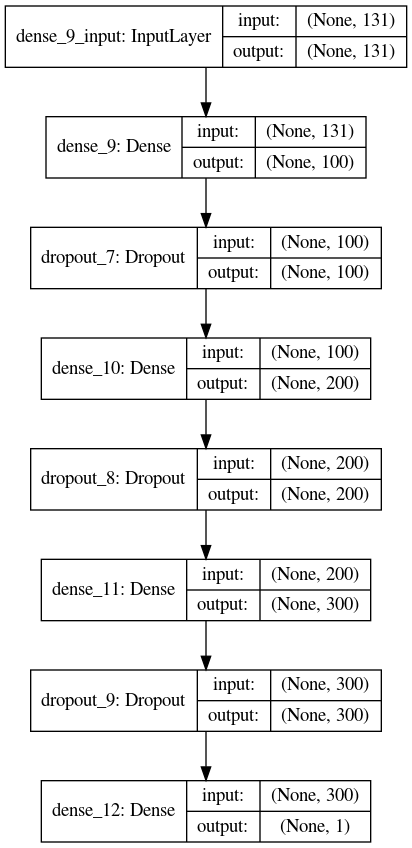

In [33]:
dense_model2 = Sequential([ 
                     Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.1),
                     Dense(200,  activation='relu'),
                     Dropout(0.1),
                     Dense(300,  activation='relu'),
                     Dropout(0.1),
                     Dense(1,   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model2, to_file=os.path.join(batch, 'dense2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense2.png'))

In [34]:
dense_model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [35]:
history = dense_model2.fit(X_train, Y_train, batch_size=505, epochs=10, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 23735 samples, validate on 1010 samples
Epoch 1/10
23735/23735 [==============================] - 1s 24us/step - loss: 0.7265 - accuracy: 0.5164 - val_loss: 0.6962 - val_accuracy: 0.5257
Epoch 2/10
23735/23735 [==============================] - 0s 18us/step - loss: 0.6892 - accuracy: 0.5224 - val_loss: 0.6852 - val_accuracy: 0.5446
Epoch 3/10
23735/23735 [==============================] - 0s 17us/step - loss: 0.6743 - accuracy: 0.5275 - val_loss: 0.6862 - val_accuracy: 0.5267
Epoch 4/10
23735/23735 [==============================] - 0s 16us/step - loss: 0.6715 - accuracy: 0.5301 - val_loss: 0.6846 - val_accuracy: 0.5396
Epoch 5/10
23735/23735 [==============================] - 0s 18us/step - loss: 0.6698 - accuracy: 0.5365 - val_loss: 0.6852 - val_accuracy: 0.5386
Epoch 6/10
23735/23735 [==============================] - 0s 17us/step - loss: 0.6694 - accuracy: 0.5344 - val_loss: 0.6835 - val_accuracy: 0.5515
Epoch 7/10
23735/23735 [==============================] - 0s 18us/ste

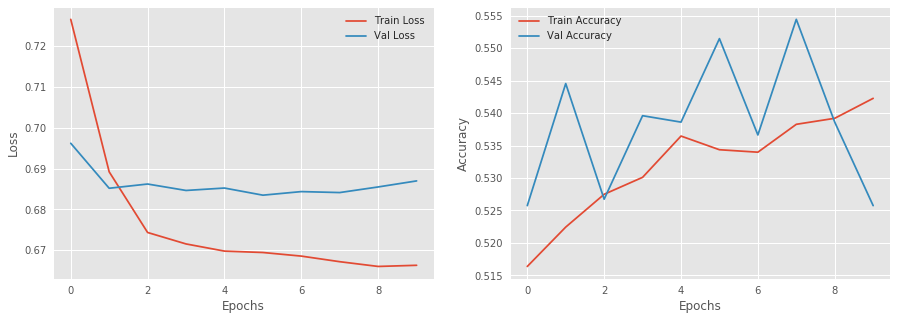

In [36]:
plot_loss_and_accuracy(history)

In [37]:
predictions = dense_model2.predict_classes(X_test).flatten()
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.516


In [38]:
predictions_full = dense_model2.predict_classes(X).flatten()
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.561


In [39]:
probs = dense_model2.predict_proba(X).flatten()
probs[:10]

array([0.52064   , 0.5155147 , 0.5381897 , 0.505762  , 0.04172021,
       0.5331863 , 0.5256823 , 0.4597736 , 0.4899663 , 0.52163935],
      dtype=float32)

Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.76      0.58       451
           1       0.62      0.32      0.42       559

    accuracy                           0.52      1010
   macro avg       0.55      0.54      0.50      1010
weighted avg       0.56      0.52      0.49      1010

Confusion Matrix : 
 [[341 110]
 [379 180]]


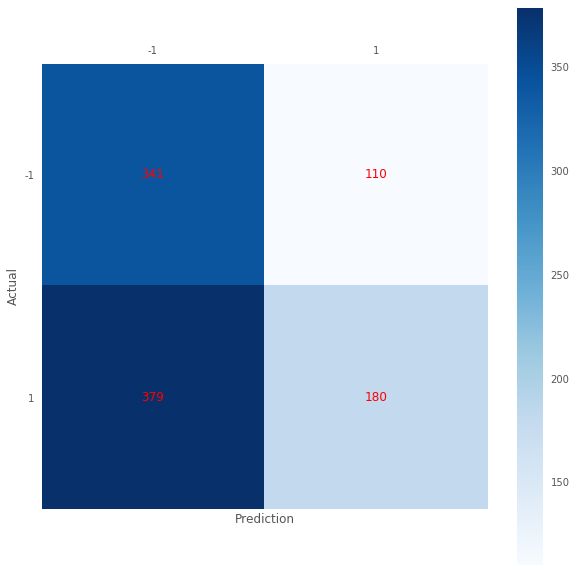

In [40]:
print_plot_metrics('DenseNetv2', Y_test, predictions)

In [41]:
print_weights_per_layer(dense_model2)

Layer : Dense : Weights : (131, 100)
Layer : Dense : Bias : (100,)
Layer : Dense : Weights : (100, 200)
Layer : Dense : Bias : (200,)
Layer : Dense : Weights : (200, 300)
Layer : Dense : Bias : (300,)
Layer : Dense : Weights : (300, 1)
Layer : Dense : Bias : (1,)


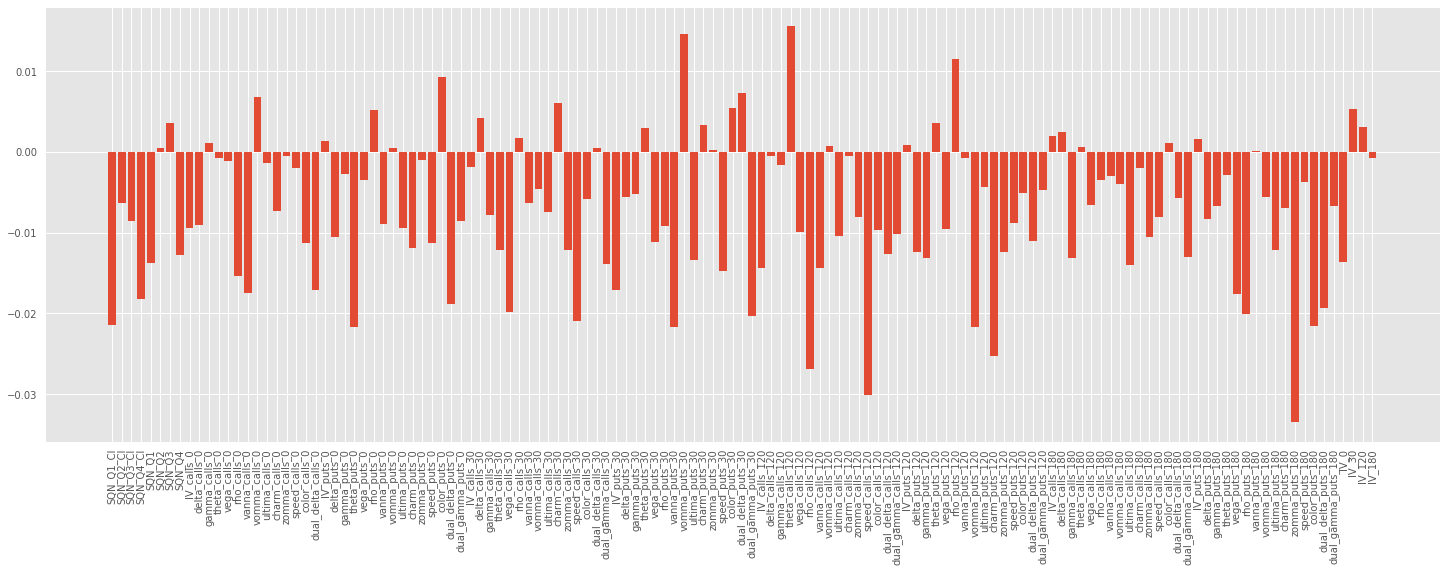

In [42]:
dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v2.png"), dpi=200)

In [134]:
def predict_dense2(data):
    probs = dense_model2.predict_proba(data)
    return np.array([[1-prob[0], prob[0]] for prob in probs])

lime_viz(j, predict_dense2)

Prediction Ticker :  AAPL
Prediction Values 1
Intercept 0.49896161265917327
Prediction_local [0.51977194]
Right: 0.5088131129741669
Intercept 0.5010383873408266
Prediction_local [0.48022806]
Right: 0.49118688702583313


In [44]:
dense_model2.save(os.path.join(batch,"dense_classifier_v2.h5"))

In [45]:
dense_model2 = load_model(os.path.join(batch,"dense_classifier_v2.h5"))

dense_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               13200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [46]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model2)

probs[:5], labels[:5]

(array([0.5458761 , 0.50834113, 0.49938452, 0.5193318 , 0.5077082 ],
       dtype=float32), array([ 1,  1, -1,  1,  1]))

In [47]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["DenseV2_Probs"] = tot_probs
combined_df_final["DenseV2_Preds"] = tot_labels

## 3. XGB Classifier

In [48]:
xgb_classif = xgb.XGBRFClassifier(n_estimators=300, max_depth=5, objective='binary:logistic', verbosity=1)

In [49]:
xgb_classif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

In [50]:
predictions = xgb_classif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.522


Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.65      0.55       451
           1       0.60      0.42      0.49       559

    accuracy                           0.52      1010
   macro avg       0.54      0.53      0.52      1010
weighted avg       0.54      0.52      0.52      1010

Confusion Matrix : 
 [[292 159]
 [324 235]]


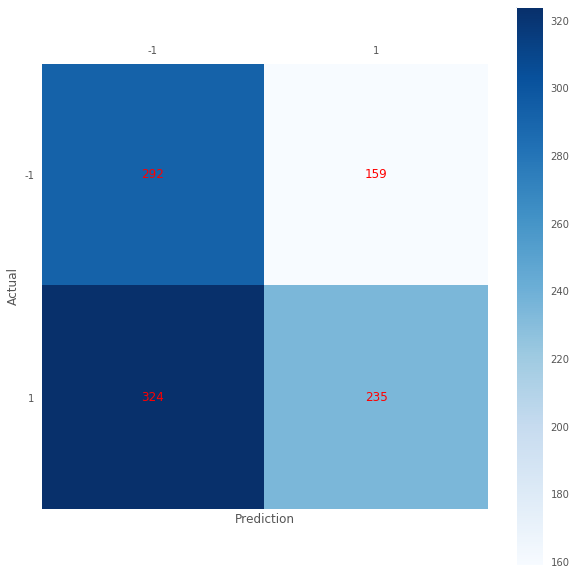

In [51]:
print_plot_metrics('XGB', Y_test, predictions)

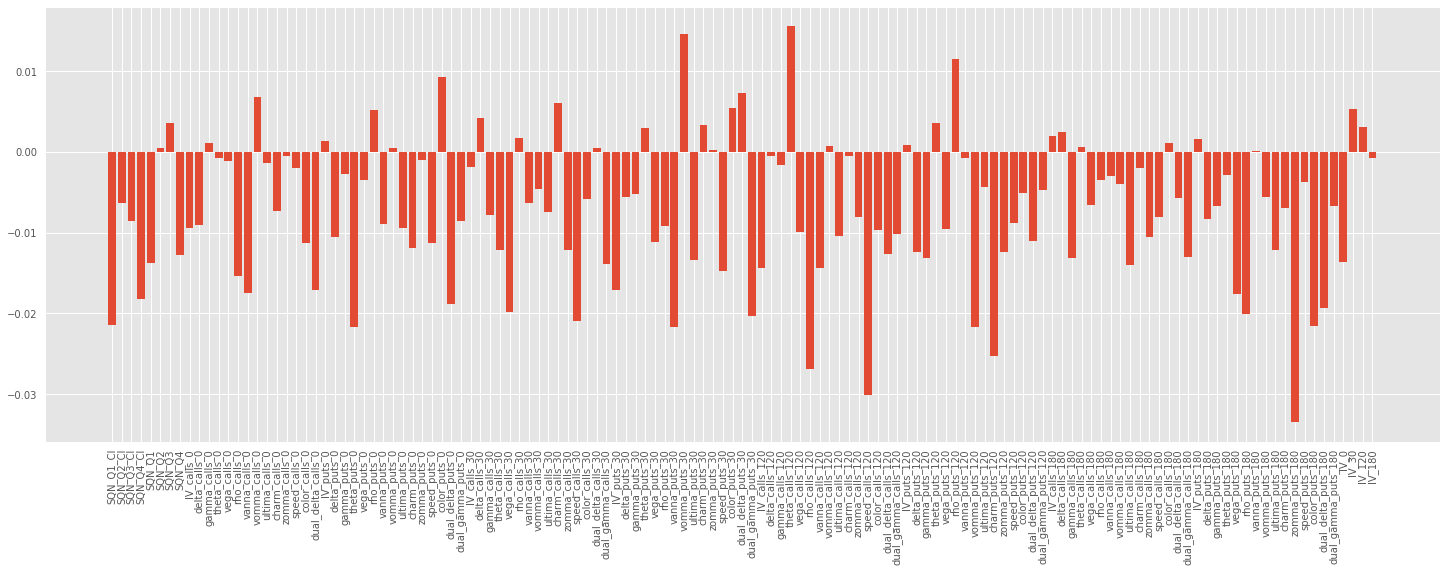

In [52]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_xgb.png"), dpi=200)

In [53]:
j=3  ## Data Sample to Analyze

In [54]:
shap.initjs()

explainerXGB = shap.TreeExplainer(xgb_classif, feature_perturbation="tree_path_dependent")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [55]:
%%time

#shap_values_XGB_train = explainerXGB.shap_values(X_train, Y_train)
shap_values_XGB_test = explainerXGB.shap_values(X_test, Y_test)

CPU times: user 827 ms, sys: 3.14 ms, total: 830 ms
Wall time: 832 ms


In [56]:
#shap.force_plot(base_value=explainerXGB.expected_value, 
#                shap_values=shap_values_XGB_train[j],
#                features = X_train[j],
#                feature_names=feature_cols)

In [57]:
shap.force_plot(base_value=explainerXGB.expected_value, 
                shap_values=shap_values_XGB_test[j],
                features = X_test[j],
                feature_names=feature_cols)

In [58]:
#shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar", feature_names=feature_cols, max_display=131)

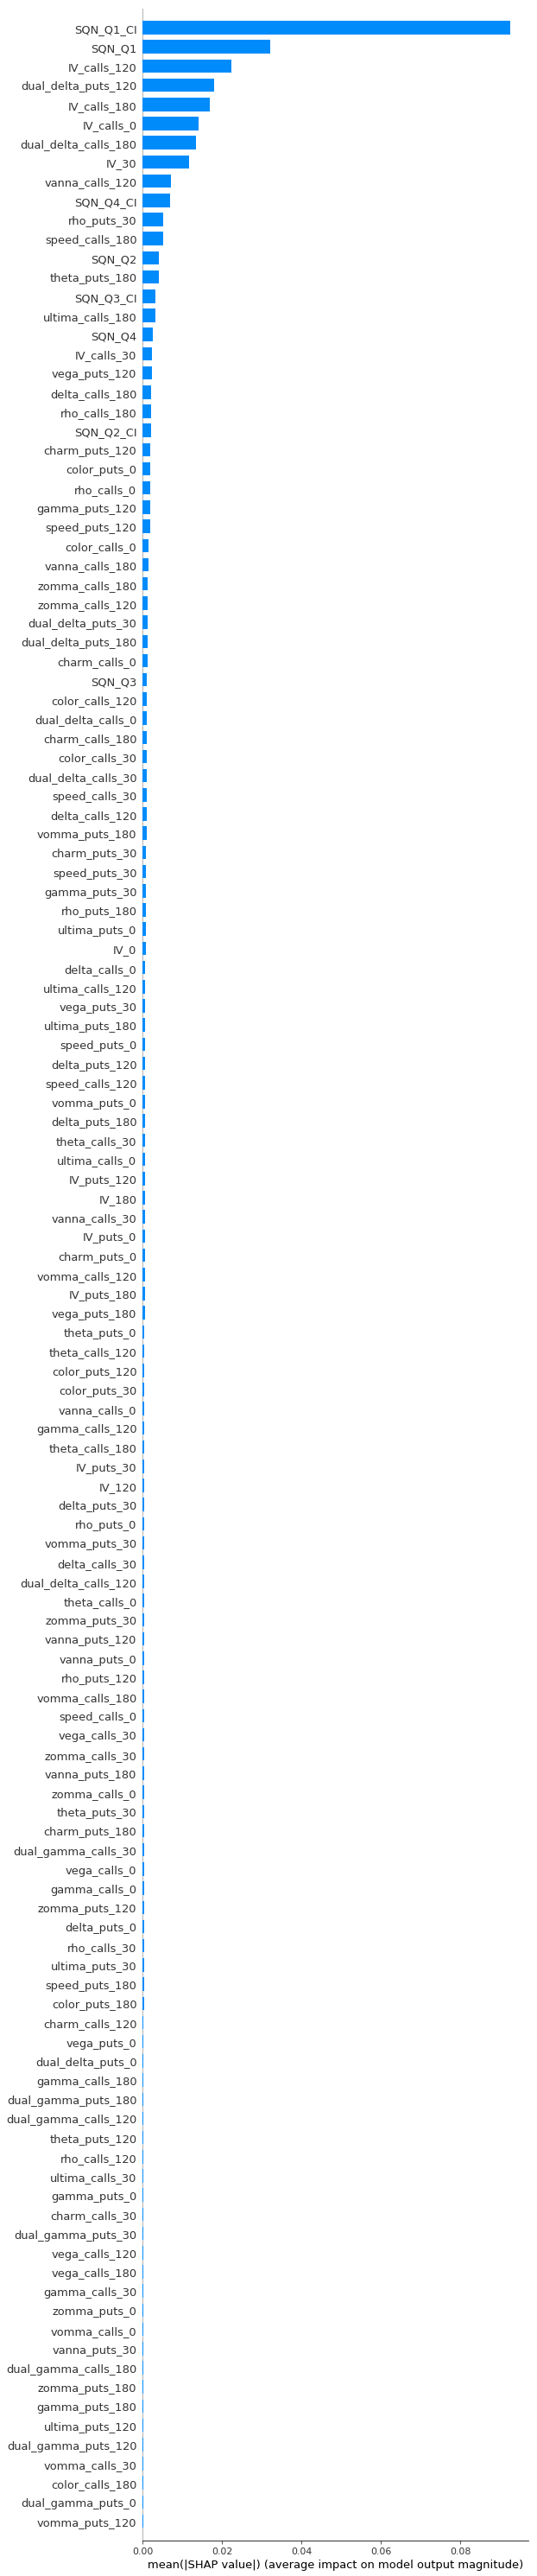

In [59]:
shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar", feature_names=feature_cols, max_display=131)

In [60]:
#shap.summary_plot(shap_values_XGB_train, X_train, feature_names=feature_cols, max_display=131)

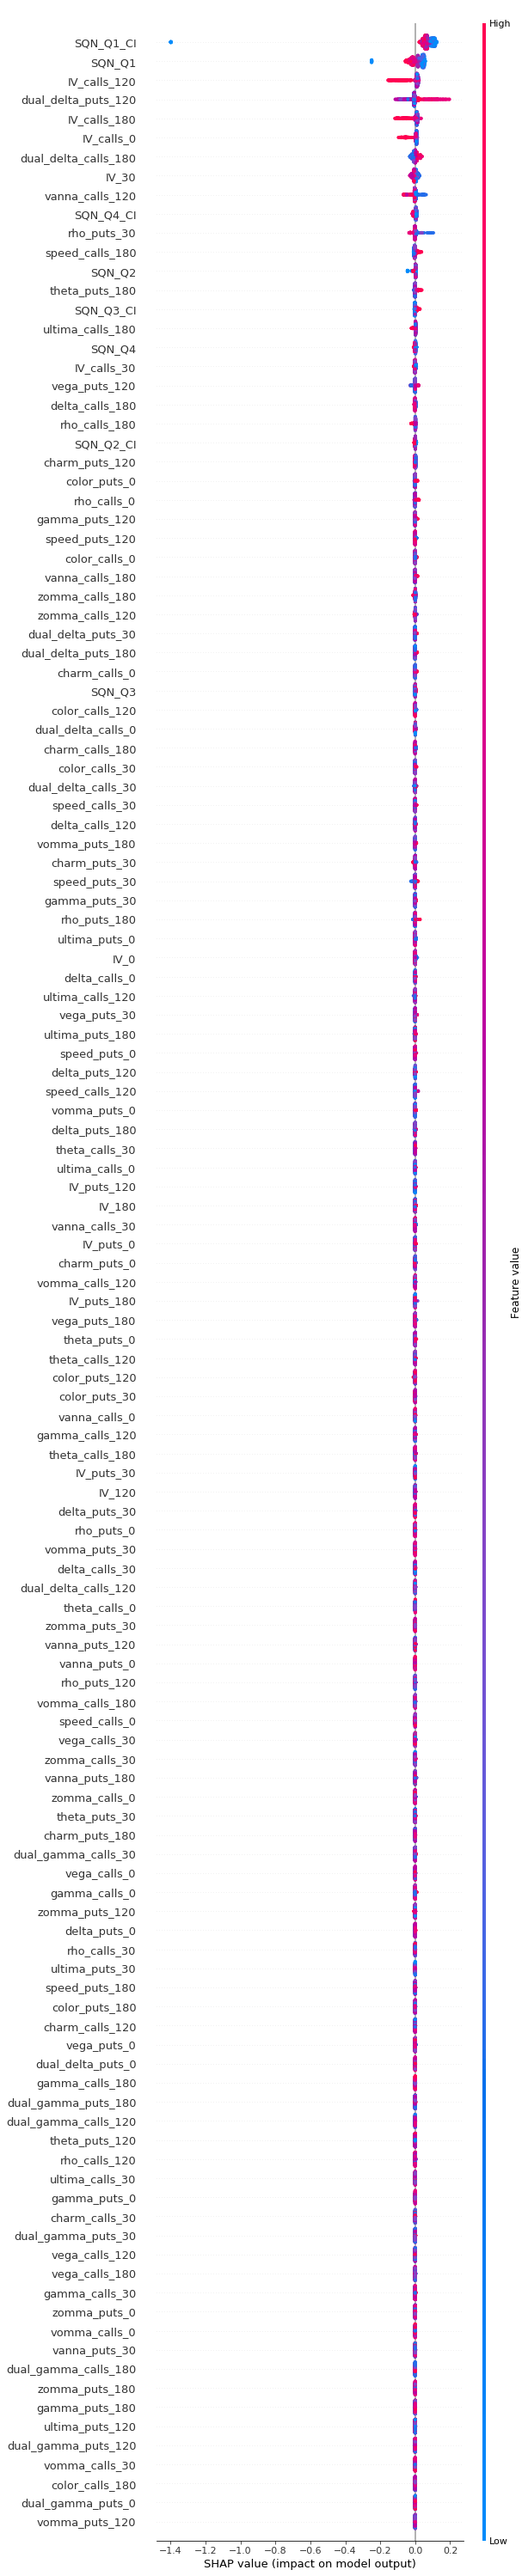

In [61]:
shap.summary_plot(shap_values_XGB_test, X_test, feature_names=feature_cols, max_display=131)

In [62]:
#shp_plt = shap.dependence_plot(feature_cols.index("SQN_Q1_CI"), shap_values_XGB_train, X_train)

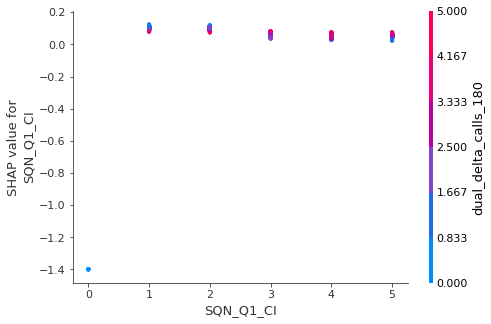

In [63]:
shp_plt = shap.dependence_plot(feature_cols.index("SQN_Q1_CI"), shap_values_XGB_test, X_test, feature_names=feature_cols)

In [135]:
j=3

lime_viz(j, xgb_classif.predict_proba)

Prediction Ticker :  AAPL
Prediction Values 1
Intercept 0.5147512376504889
Prediction_local [0.58114834]
Right: 0.4710828
Intercept 0.48524876235119274
Prediction_local [0.41885166]
Right: 0.5289172


In [65]:
probs = xgb_classif.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.49202678, 0.48177403, 0.49313042, 0.5289172 , 0.46752343],
      dtype=float32)

In [66]:
pickle.dump(xgb_classif, open(os.path.join(batch,"xgb_classif.pkl"), "wb"))

xgb_classif_loaded = pickle.load(open(os.path.join(batch,"xgb_classif.pkl"), "rb"))

xgb_classif_loaded

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=5, min_child_weight=1, missing=nan, n_estimators=300,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

In [67]:
probs = xgb_classif_loaded.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.49202678, 0.48177403, 0.49313042, 0.5289172 , 0.46752343],
      dtype=float32)

In [68]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    if use_tickers_as_feature:
        df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"])
    df = df.fillna(value=0)

    data = df.values

    prediction_probs = model.predict_proba(data)
    prediction_probs = prediction_probs[:,1]
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

probs, labels = future_predictions(last_file, xgb_classif)

probs[:5], labels[:5]

(array([0.5092866 , 0.47371823, 0.48617527, 0.5241428 , 0.50842786],
       dtype=float32), array([ 1, -1, -1,  1,  1]))

In [69]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, xgb_classif)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["XGB_Probs"] = tot_probs
combined_df_final["XGB_Preds"] = tot_labels

## 4. LSTM V1

In [70]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    if use_tickers_as_feature:
        df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"]).fillna(value=0)
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 131) (52, 505)


In [71]:
X, Y = total_data[:-1], labels[1:]

print(X.shape, Y.shape)

X_train, X_test = X[:49], X[49:]
Y_train, Y_test = Y[:49], Y[49:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(51, 505, 131) (51, 505)


((49, 505, 131), (2, 505, 131), (49, 505), (2, 505))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                36400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 505)               25755     
Total params: 62,155
Trainable params: 62,155
Non-trainable params: 0
_________________________________________________________________
None


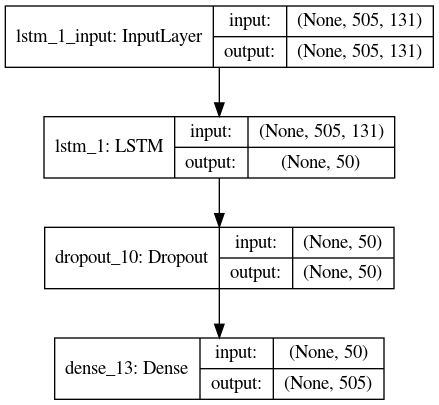

In [72]:
lstm_classif_v1 = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.1),
                        Dense(Y_train.shape[1], activation='sigmoid')                        
                        ])

print(lstm_classif_v1.summary())

plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif1.png'))

In [73]:
lstm_classif_v1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
history = lstm_classif_v1.fit(X_train, Y_train, epochs=15, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/15
 - 3s - loss: 0.6919 - accuracy: 0.5184 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 2/15
 - 3s - loss: 0.6769 - accuracy: 0.5604 - val_loss: 0.6975 - val_accuracy: 0.4997
Epoch 3/15
 - 3s - loss: 0.6659 - accuracy: 0.5789 - val_loss: 0.7029 - val_accuracy: 0.4957
Epoch 4/15
 - 3s - loss: 0.6588 - accuracy: 0.5824 - val_loss: 0.7058 - val_accuracy: 0.4931
Epoch 5/15
 - 3s - loss: 0.6545 - accuracy: 0.5938 - val_loss: 0.7053 - val_accuracy: 0.4931
Epoch 6/15
 - 3s - loss: 0.6506 - accuracy: 0.5988 - val_loss: 0.7078 - val_accuracy: 0.4858
Epoch 7/15
 - 3s - loss: 0.6487 - accuracy: 0.6019 - val_loss: 0.7074 - val_accuracy: 0.4924
Epoch 8/15
 - 3s - loss: 0.6466 - accuracy: 0.6033 - val_loss: 0.7081 - val_accuracy: 0.4950
Epoch 9/15
 - 3s - loss: 0.6447 - accuracy: 0.6070 - val_loss: 0.7094 - val_accuracy: 0.4950
Epoch 10/15
 - 3s - loss: 0.6426 - accuracy: 0.6138 - val_loss: 0.7084 - val_accuracy: 0.4858
Epoch 11/15
 - 3s - loss: 

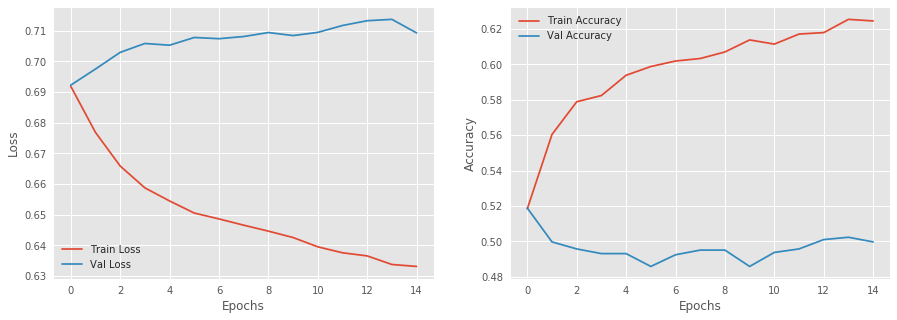

In [75]:
plot_loss_and_accuracy(history)

In [76]:
predictions = lstm_classif_v1.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.520


Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.66      0.55       451
           1       0.60      0.41      0.49       559

    accuracy                           0.52      1010
   macro avg       0.53      0.53      0.52      1010
weighted avg       0.54      0.52      0.51      1010

Confusion Matrix : 
 [[296 155]
 [330 229]]


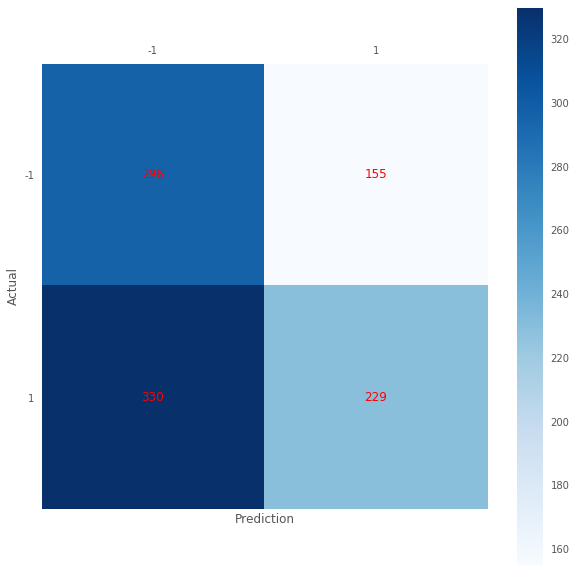

In [77]:
print_plot_metrics('LSTMV1', Y_test.flatten(), predictions_labels.flatten())

In [78]:
print_weights_per_layer(lstm_classif_v1)

Layer : LSTM : Weights : (131, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


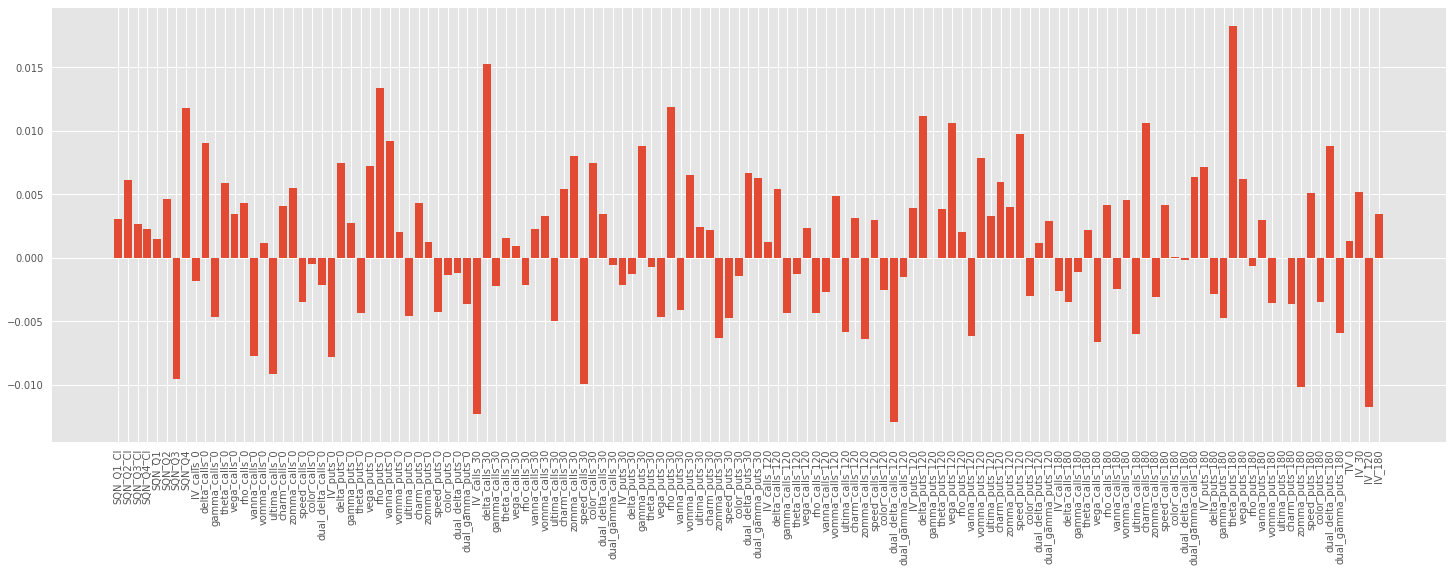

In [79]:
lstm_weights = lstm_classif_v1.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v1.png"), dpi=200)

In [81]:
lstm_classif_v1.save(os.path.join(batch,"lstm_classifier_v1.h5"))

In [82]:
lstm_classif_v1 = load_model(os.path.join(batch,"lstm_classifier_v1.h5"))

lstm_classif_v1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                36400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 505)               25755     
Total params: 62,155
Trainable params: 62,155
Non-trainable params: 0
_________________________________________________________________


In [83]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    if use_tickers_as_feature:
        df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [84]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v1)

probs[:5], labels[:5]

(array([0.46298727, 0.5143318 , 0.53861535, 0.6362168 , 0.5240656 ],
       dtype=float32), array([-1,  1,  1,  1,  1]))

In [85]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V1_Probs"] = tot_probs
combined_df_final["LSTM_V1_Preds"] = tot_labels

## 5. LSTM V2

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 100)          92800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 50)           30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_14 (Dense)             (None, 505)               15655     
Total params: 148,375
Trainable params: 148,375
Non-trainable params: 0
_________________________________________________________________
None


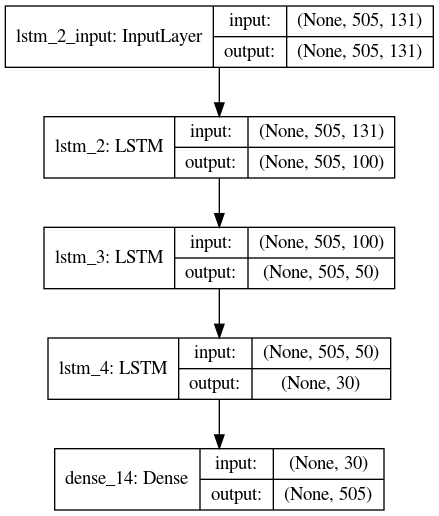

In [86]:
lstm_classif_v2 = Sequential([
                LSTM(units=100, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=50, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train.shape[1], activation='sigmoid')
                ])

print(lstm_classif_v2.summary())

plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif2.png'))

In [87]:
lstm_classif_v2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
history = lstm_classif_v2.fit(X_train, Y_train, epochs=15, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/15
 - 11s - loss: 0.6905 - accuracy: 0.5197 - val_loss: 0.6904 - val_accuracy: 0.5182
Epoch 2/15
 - 10s - loss: 0.6769 - accuracy: 0.5584 - val_loss: 0.6966 - val_accuracy: 0.5175
Epoch 3/15
 - 9s - loss: 0.6674 - accuracy: 0.5656 - val_loss: 0.7033 - val_accuracy: 0.5162
Epoch 4/15
 - 10s - loss: 0.6643 - accuracy: 0.5734 - val_loss: 0.7059 - val_accuracy: 0.5096
Epoch 5/15
 - 9s - loss: 0.6633 - accuracy: 0.5745 - val_loss: 0.7069 - val_accuracy: 0.5076
Epoch 6/15
 - 9s - loss: 0.6627 - accuracy: 0.5738 - val_loss: 0.7075 - val_accuracy: 0.5076
Epoch 7/15
 - 10s - loss: 0.6623 - accuracy: 0.5735 - val_loss: 0.7078 - val_accuracy: 0.5089
Epoch 8/15
 - 11s - loss: 0.6620 - accuracy: 0.5752 - val_loss: 0.7078 - val_accuracy: 0.5096
Epoch 9/15
 - 9s - loss: 0.6615 - accuracy: 0.5759 - val_loss: 0.7077 - val_accuracy: 0.5069
Epoch 10/15
 - 9s - loss: 0.6607 - accuracy: 0.5775 - val_loss: 0.7071 - val_accuracy: 0.5089
Epoch 11/15
 - 9s - l

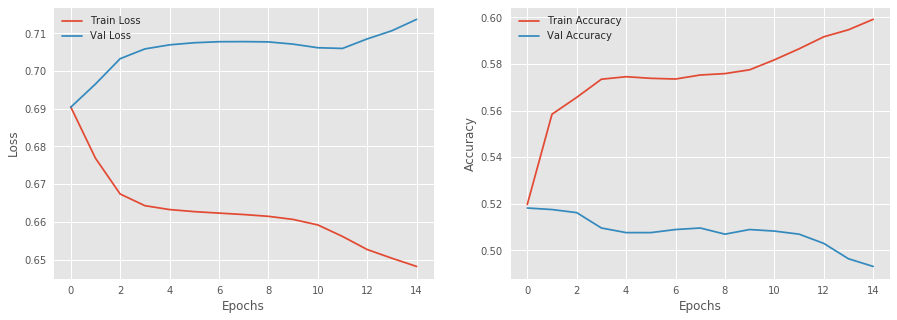

In [89]:
plot_loss_and_accuracy(history)

In [90]:
predictions = lstm_classif_v2.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.528


Classification Report : 
               precision    recall  f1-score   support

           0       0.48      0.63      0.55       451
           1       0.60      0.44      0.51       559

    accuracy                           0.53      1010
   macro avg       0.54      0.54      0.53      1010
weighted avg       0.55      0.53      0.53      1010

Confusion Matrix : 
 [[286 165]
 [312 247]]


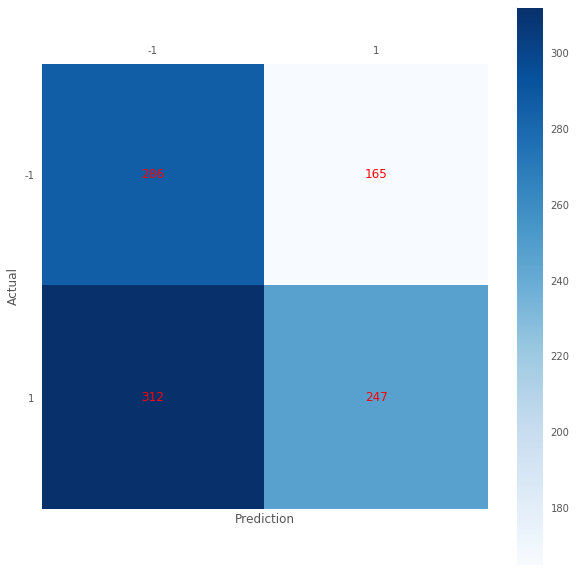

In [91]:
print_plot_metrics('LSTMV2', Y_test.flatten(), predictions_labels.flatten())

In [92]:
print_weights_per_layer(lstm_classif_v2)

Layer : LSTM : Weights : (131, 400)
Layer : LSTM : Weights : (100, 400)
Layer : LSTM : Weights : (400,)
Layer : Dense : Weights : (100, 200)
Layer : Dense : Bias : (50, 200)


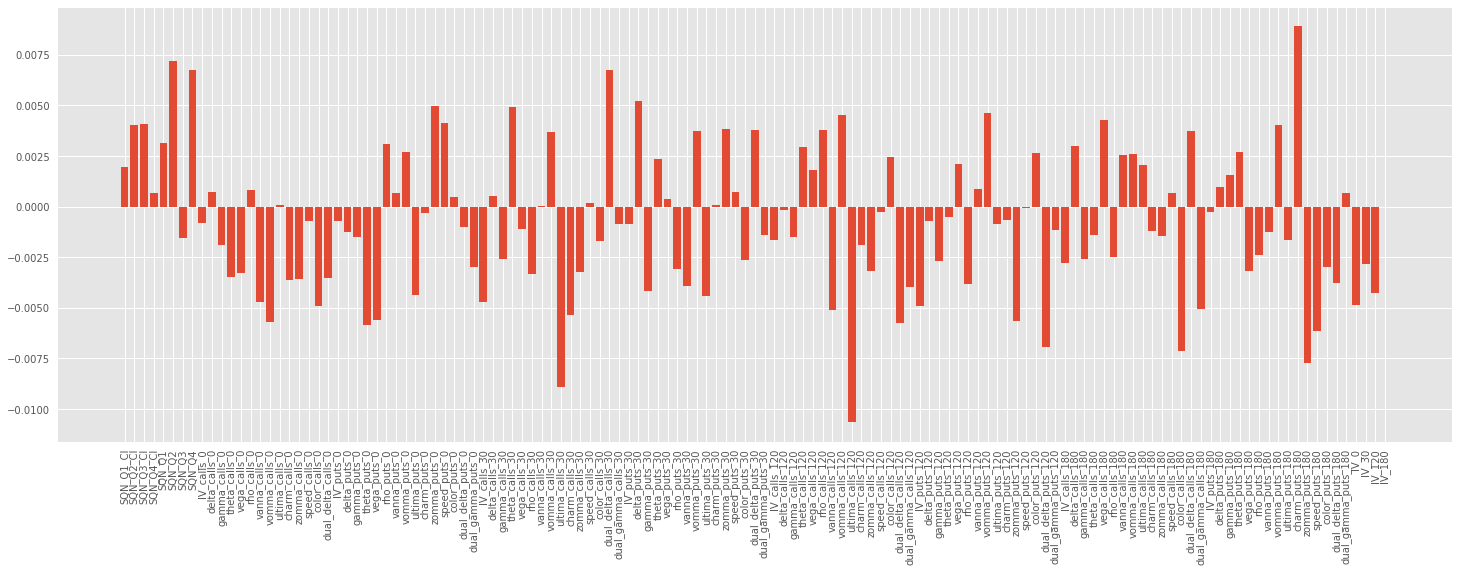

In [93]:
lstm_weights = lstm_classif_v2.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v2.png"), dpi=200)

In [90]:
#def predict_lstmv2(data):
#    probs = lstm_classif_v2.predict_proba(data)
#    return np.array([[1-prob[0], prob[0]] for prob in probs])

#lime_viz(j, predict_lstmv2)

In [94]:
lstm_classif_v2.save(os.path.join(batch,"lstm_classifier_v2.h5"))

In [95]:
lstm_classif_v2 = load_model(os.path.join(batch,"lstm_classifier_v2.h5"))

lstm_classif_v2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 100)          92800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 50)           30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_14 (Dense)             (None, 505)               15655     
Total params: 148,375
Trainable params: 148,375
Non-trainable params: 0
_________________________________________________________________


In [96]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v2)

probs[:5], labels[:5]

(array([0.58487874, 0.51159024, 0.4672735 , 0.6197436 , 0.54087955],
       dtype=float32), array([ 1,  1, -1,  1,  1]))

In [97]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v2)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V2_Probs"] = tot_probs
combined_df_final["LSTM_V2_Preds"] = tot_labels

## 6. CNN LSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 32)     4224      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 8064)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               3266000   
_________________________________________________________________
dense_15 (Dense)             (None, 505)               51005     
Total params: 3,321,229
Trainable params: 3,321,229
Non-trainable params: 0
_________________________________________________________________
None


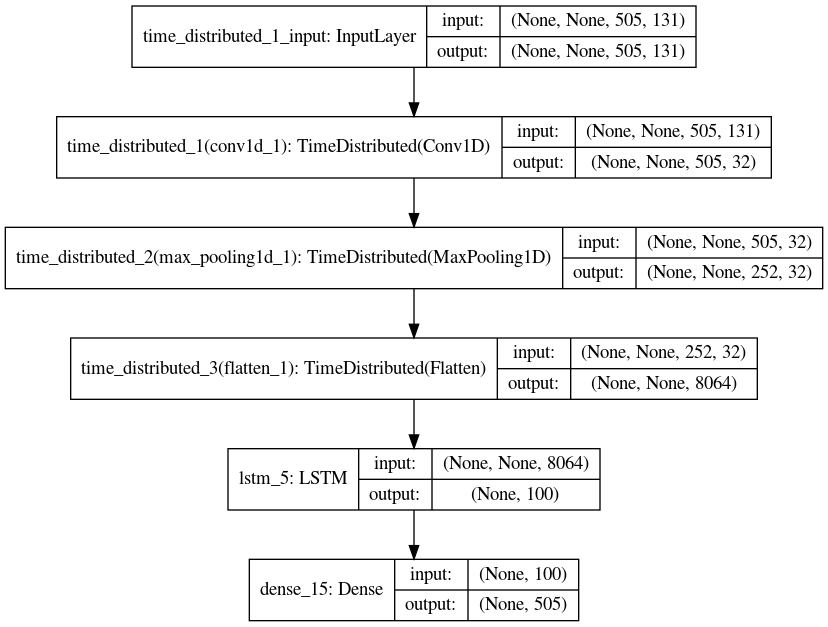

In [98]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, activation='relu'),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v3.summary())

plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif3.png'))

In [99]:
lstm_classif_v3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train, epochs=15, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/15
 - 4s - loss: 0.7158 - accuracy: 0.5219 - val_loss: 0.6928 - val_accuracy: 0.5023
Epoch 2/15
 - 2s - loss: 0.6916 - accuracy: 0.5711 - val_loss: 0.6925 - val_accuracy: 0.5063
Epoch 3/15
 - 2s - loss: 0.6901 - accuracy: 0.5752 - val_loss: 0.6922 - val_accuracy: 0.5135
Epoch 4/15
 - 2s - loss: 0.6888 - accuracy: 0.5793 - val_loss: 0.6920 - val_accuracy: 0.5122
Epoch 5/15
 - 2s - loss: 0.6876 - accuracy: 0.5804 - val_loss: 0.6918 - val_accuracy: 0.5102
Epoch 6/15
 - 2s - loss: 0.6865 - accuracy: 0.5808 - val_loss: 0.6916 - val_accuracy: 0.5089
Epoch 7/15
 - 2s - loss: 0.6854 - accuracy: 0.5812 - val_loss: 0.6914 - val_accuracy: 0.5089
Epoch 8/15
 - 2s - loss: 0.6844 - accuracy: 0.5813 - val_loss: 0.6913 - val_accuracy: 0.5083
Epoch 9/15
 - 2s - loss: 0.6834 - accuracy: 0.5812 - val_loss: 0.6912 - val_accuracy: 0.5083
Epoch 10/15
 - 3s - loss: 0.6824 - accuracy: 0.5811 - val_loss: 0.6911 - val_accuracy: 0.5083
Epoch 11/15
 - 3s - loss: 

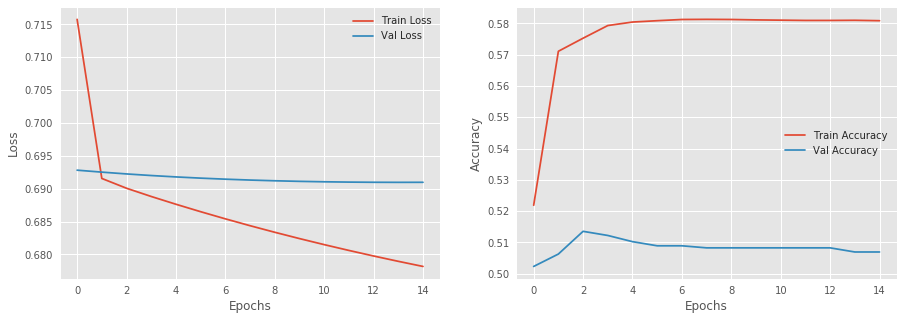

In [101]:
plot_loss_and_accuracy(history)

In [102]:
predictions = lstm_classif_v3.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.499


Classification Report : 
               precision    recall  f1-score   support

           0       0.46      0.65      0.53       451
           1       0.57      0.38      0.46       559

    accuracy                           0.50      1010
   macro avg       0.51      0.51      0.50      1010
weighted avg       0.52      0.50      0.49      1010

Confusion Matrix : 
 [[291 160]
 [346 213]]


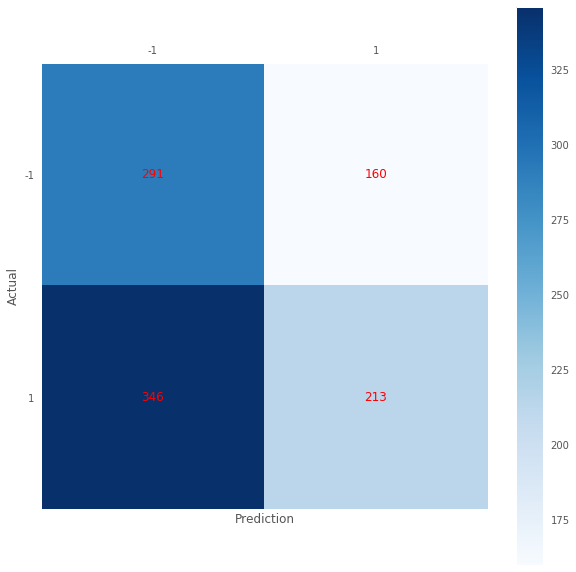

In [103]:
print_plot_metrics('LSTMV3', Y_test.flatten(), predictions_labels.flatten())

In [104]:
print_weights_per_layer(lstm_classif_v3)

Layer : TimeDistributed : Weights : (1, 131, 32)
Layer : TimeDistributed : Weights : (32,)
Layer : TimeDistributed : Weights : (8064, 400)
Layer : LSTM : Weights : (100, 400)
Layer : Dense : Weights : (400,)
Layer : Dense : Bias : (100, 505)


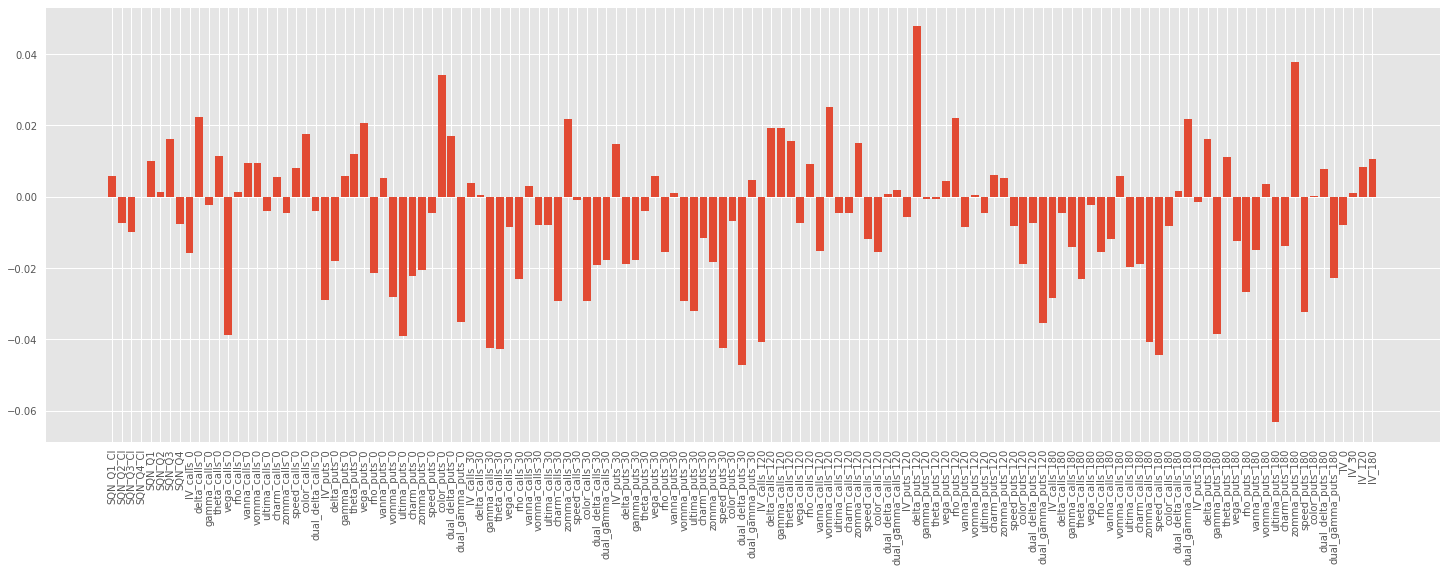

In [105]:
lstm_weights = lstm_classif_v3.get_weights()
important_weights = lstm_weights[0].mean(axis=2).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v3.png"), dpi=200)

In [106]:
#def predict_lstmv3(data):
#    probs = lstm_classif_v3.predict_proba(data)
#    return np.array([[1-prob[0], prob[0]] for prob in probs])

#lime_viz(j, predict_lstmv3)

In [107]:
lstm_classif_v3.save(os.path.join(batch,"lstm_classifier_v3.h5"))

In [108]:
lstm_classif_v3 = load_model(os.path.join(batch,"lstm_classifier_v3.h5"))

lstm_classif_v3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 32)     4224      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 8064)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               3266000   
_________________________________________________________________
dense_15 (Dense)             (None, 505)               51005     
Total params: 3,321,229
Trainable params: 3,321,229
Non-trainable params: 0
_________________________________________________________________


In [109]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    if use_tickers_as_feature:
        df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [110]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v3)

probs[:5], labels[:5]

(array([0.5250151 , 0.49906236, 0.5066833 , 0.5377255 , 0.4867095 ],
       dtype=float32), array([ 1, -1,  1,  1, -1]))

In [111]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v3)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V3_Probs"] = tot_probs
combined_df_final["LSTM_V3_Preds"] = tot_labels

## 7. ConvLSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        100096    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 505)               16289785  
Total params: 16,389,881
Trainable params: 16,389,881
Non-trainable params: 0
_________________________________________________________________
None


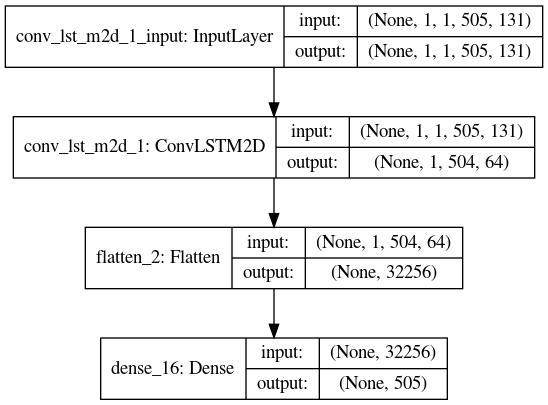

In [112]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v4.summary())

plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif4.png'))

In [113]:
lstm_classif_v4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs=15, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/15
 - 31s - loss: 0.7669 - accuracy: 0.5344 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 2/15
 - 14s - loss: 0.6598 - accuracy: 0.5935 - val_loss: 0.6887 - val_accuracy: 0.5109
Epoch 3/15
 - 11s - loss: 0.6316 - accuracy: 0.6353 - val_loss: 0.6879 - val_accuracy: 0.5116
Epoch 4/15
 - 11s - loss: 0.5807 - accuracy: 0.6969 - val_loss: 0.7003 - val_accuracy: 0.5089
Epoch 5/15
 - 11s - loss: 0.4776 - accuracy: 0.7785 - val_loss: 0.7642 - val_accuracy: 0.4964
Epoch 6/15
 - 11s - loss: 0.3464 - accuracy: 0.8539 - val_loss: 0.8443 - val_accuracy: 0.4845
Epoch 7/15
 - 12s - loss: 0.2299 - accuracy: 0.9120 - val_loss: 1.0365 - val_accuracy: 0.4785
Epoch 8/15
 - 12s - loss: 0.1655 - accuracy: 0.9437 - val_loss: 1.1528 - val_accuracy: 0.4832
Epoch 9/15
 - 11s - loss: 0.1186 - accuracy: 0.9582 - val_loss: 1.5572 - val_accuracy: 0.4878
Epoch 10/15
 - 12s - loss: 0.0752 - accuracy: 0.9751 - val_loss: 1.8089 - val_accuracy: 0.4904
Epoch 11/15
 - 1

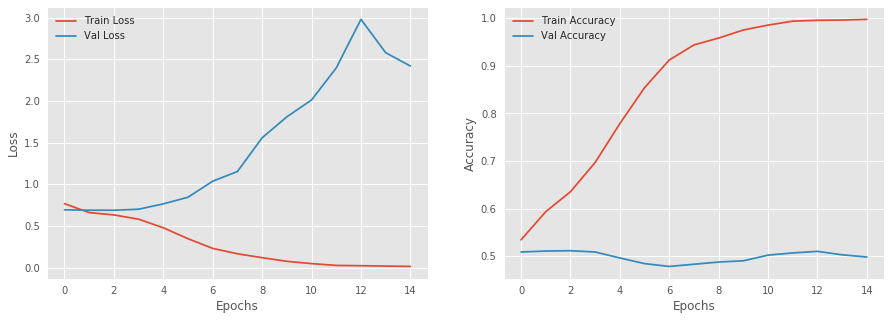

In [115]:
plot_loss_and_accuracy(history)

In [116]:
predictions = lstm_classif_v4.predict(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.528


Classification Report : 
               precision    recall  f1-score   support

           0       0.48      0.56      0.52       451
           1       0.59      0.50      0.54       559

    accuracy                           0.53      1010
   macro avg       0.53      0.53      0.53      1010
weighted avg       0.54      0.53      0.53      1010

Confusion Matrix : 
 [[254 197]
 [280 279]]


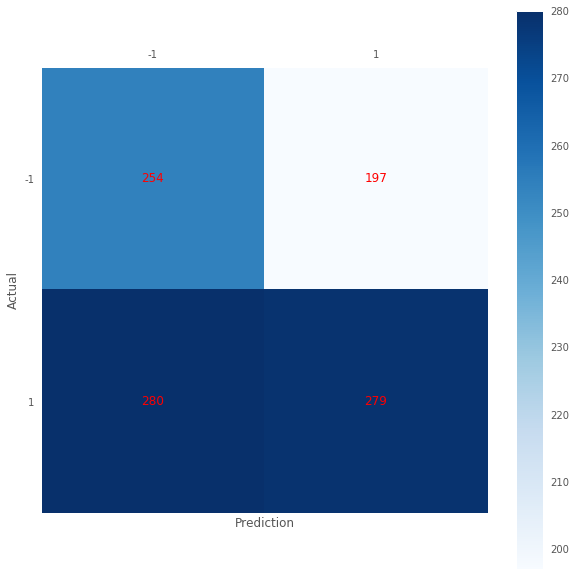

In [117]:
print_plot_metrics('LSTMV4', Y_test.flatten(), predictions_labels.flatten())

In [118]:
print_weights_per_layer(lstm_classif_v4)

Layer : ConvLSTM2D : Weights : (1, 2, 131, 256)
Layer : Flatten : Weights : (1, 2, 64, 256)
Layer : Dense : Weights : (256,)
Layer : Dense : Bias : (32256, 505)


(1, 2, 131, 256)


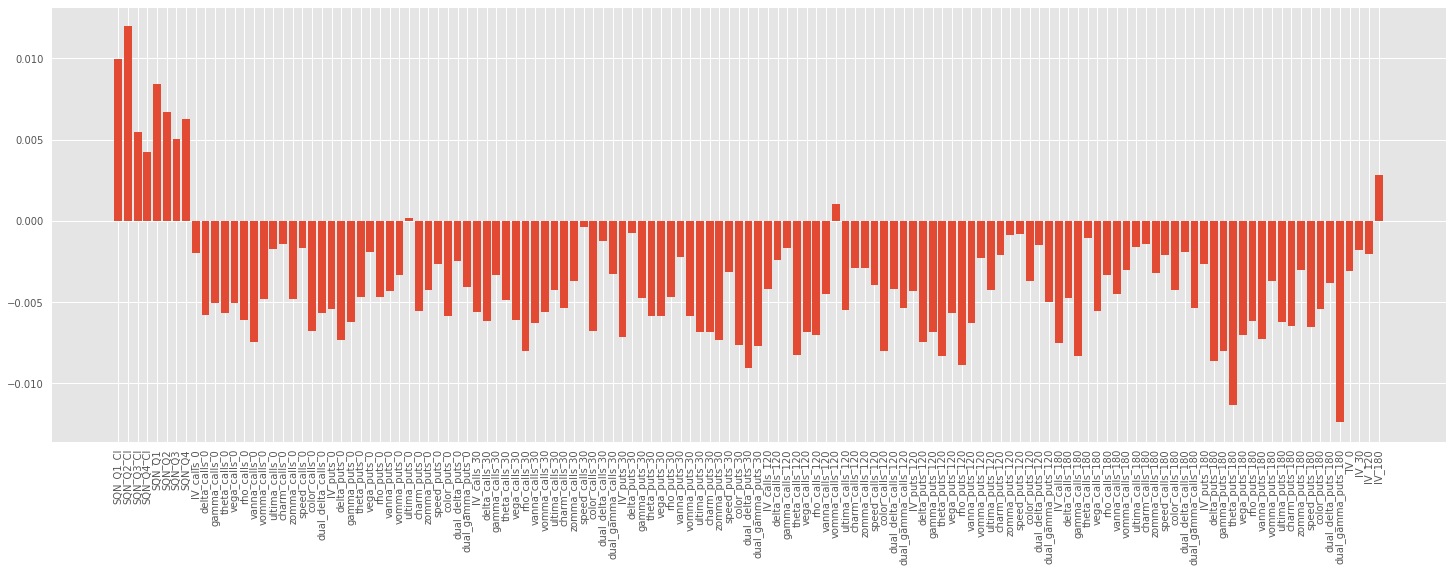

In [119]:
lstm_weights = lstm_classif_v4.get_weights()
print(lstm_weights[0].shape)
important_weights = lstm_weights[0].mean(axis=3).mean(axis=1).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    if use_tickers_as_feature:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    else:
        plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v4.png"), dpi=200)

In [120]:
#def predict_lstmv4(data):
#    probs = lstm_classif_v4.predict_proba(data)
#    return np.array([[1-prob[0], prob[0]] for prob in probs])

#lime_viz(j, predict_lstmv4)

In [121]:
lstm_classif_v4.save(os.path.join(batch,"lstm_classifier_v4.h5"))

In [122]:
lstm_classif_v4 = load_model(os.path.join(batch,"lstm_classifier_v4.h5"))

lstm_classif_v4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        100096    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 505)               16289785  
Total params: 16,389,881
Trainable params: 16,389,881
Non-trainable params: 0
_________________________________________________________________


In [123]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    if use_tickers_as_feature:
        df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    else:
        df = df.drop(columns=["ticker", "returns"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [124]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v4)

probs[:5], labels[:5]

(array([0.49021047, 0.08707839, 0.40128857, 0.7344703 , 0.05497676],
       dtype=float32), array([-1, -1, -1,  1, -1]))

In [125]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v4)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V4_Probs"] = tot_probs
combined_df_final["LSTM_V4_Preds"] = tot_labels

## Writing Final CSV With Probs & Predicted Labels to Disk

In [126]:
combined_df_final.tail()

ticker  SQN_Q1_CI  SQN_Q2_CI  SQN_Q3_CI  SQN_Q4_CI  SQN_Q1  SQN_Q2  \
500    YUM        3.0        1.0        1.0        5.0     3.0     1.0   
501    ZBH        3.0        1.0        5.0        3.0     3.0     2.0   
502   ZBRA        2.0        2.0        4.0        1.0     2.0     2.0   
503   ZION        3.0        4.0        5.0        1.0     3.0     4.0   
504    ZTS        2.0        1.0        1.0        5.0     2.0     1.0   

     SQN_Q3  SQN_Q4  IV_calls_0  ...  XGB_Probs  XGB_Preds  LSTM_V1_Probs  \
500     1.0     5.0         4.0  ...   0.466738         -1       0.490167   
501     5.0     3.0         4.0  ...   0.495061         -1       0.422248   
502     3.0     1.0         1.0  ...   0.530507          1       0.573817   
503     5.0     1.0         3.0  ...   0.515914          1       0.472003   
504     1.0     5.0         4.0  ...   0.503353          1       0.554259   

     LSTM_V1_Preds  LSTM_V2_Probs  LSTM_V2_Preds  LSTM_V3_Probs  \
500             -1       0.507939              1       0.513166   
501             -1       0.414293             -1       0.468237   
502              1       0.480097             -1       0.492946   
503             -1       0.482012             -1       0.488397   
504              1       0.545912              1       0.460071   

     LSTM_V3_Preds  LSTM_V4_Probs  LSTM_V4_Preds  
500              1       0.133927             -1  
501             -1       0.138297             -1  
502             -1       0.960015              1  
503             -1       0.438956             -1  
504             -1       0.995625              1  

[5 rows x 147 columns]

In [127]:
combined_df_final.to_csv(os.path.join(batch,"final.csv"))

In [128]:
combined_df_final[-(505 *2):].to_csv(os.path.join(batch,"test_probs.csv"))